In [1]:
# Import useful things

import numpy as np      
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import rcParams
import matplotlib.dates as md
import os
import glob

# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='8'
rcParams['ytick.major.pad']='8'

# Supress warnings for notebook ease of use
import warnings
warnings.filterwarnings("ignore")

In [29]:

# To unzip all files:
# unzip '*.zip'

# Merge all the hourly netcdfs for that day. 
import netCDF4
from netCDF4 import Dataset

# MMCR data location
dloc = '/Users/heather/Desktop/temp_data/temp_radar_data/'
#'/Volumes/Data/ICECAPSarchive/MMCR/'

# Date of interest
start = dt.datetime(2019,7,2,0)
stop = dt.datetime(2019,7,3,18)
all_files = []

f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
flatten = lambda l: [item for sublist in l for item in sublist]

for date in f_date_list:
    day_of_year = (date.date()).timetuple().tm_yday
    floc = dloc + dt.datetime.strftime(date,format='%Y%m%d')
    all_files.append(glob.glob(floc+ '/*MMCRMom*'))


all_files = flatten(all_files)
all_files.sort()
#mmcr_nc = netCDF4.MFDataset(all_files,'r')

# Radar mode (0,1,2,3) (time)
# Use general mode for now, that is ...
mode = 2

mmcr_nc = netCDF4.MFDataset(all_files,'r')

# Get heights for particular mode
# Range Heights (center of radar sample volume), magl.
# (mode, heights)
Heights = mmcr_nc.variables['Heights'][mode,:]
Heights = Heights[Heights.mask == False]

# Get mode/ time
ModeNum = mmcr_nc.variables['ModeNum'][:]    

    
# Get data quality status and subset for modes
DataQualityStatus = mmcr_nc.variables['DataQualityStatus'][:]
DataQualityStatus = DataQualityStatus[np.where(ModeNum==2)]

# Get Signal to Noise ratio
# dB, (time, heights)
# Remove signal to noise ratio < -14
SignalToNoiseRatio = mmcr_nc.variables['SignalToNoiseRatio'][:,0:len(Heights)]
SignalToNoiseRatio = SignalToNoiseRatio[np.where(ModeNum==2)]

# Get mean doppler velocity and subset for mode and heights. Remove bad s2n. 
# m/s, (time, heights)
MeanDopplerVelocity = mmcr_nc.variables['MeanDopplerVelocity'][:,0:len(Heights)]
MeanDopplerVelocity = MeanDopplerVelocity[np.where(ModeNum==2)]
MeanDopplerVelocity = np.ma.masked_where(SignalToNoiseRatio<-14,MeanDopplerVelocity)

# Get reflectivity and subset for mode and heights. Remove bad s2n. 
# Reflectiity, dBZ (time, heights)
Reflectivity = mmcr_nc.variables['Reflectivity'][:,0:len(Heights)]
Reflectivity = Reflectivity[np.where(ModeNum==2)]
Reflectivity = np.ma.masked_where(SignalToNoiseRatio<-14,Reflectivity)   



In [30]:
# Get times: 

for i in range(0, len(all_files)):
    mmcr_temp = netCDF4.Dataset(all_files[i],'r')
    
    # Get mode/ time
    ModeNum = mmcr_temp.variables['ModeNum'][:] 

    # Time offset from base time
    # Get netcdf units to convert (i.e. seconds since 2019-08-10 0200)
    time_var = mmcr_temp.variables['time_offset']
    dtime = netCDF4.num2date(time_var[:],time_var.units)

    # Subset times for mode
    times = dtime[np.where(ModeNum==mode)]
        
    if i==0:
        all_times = times

    else:
        all_times = np.append(all_times,times)
    


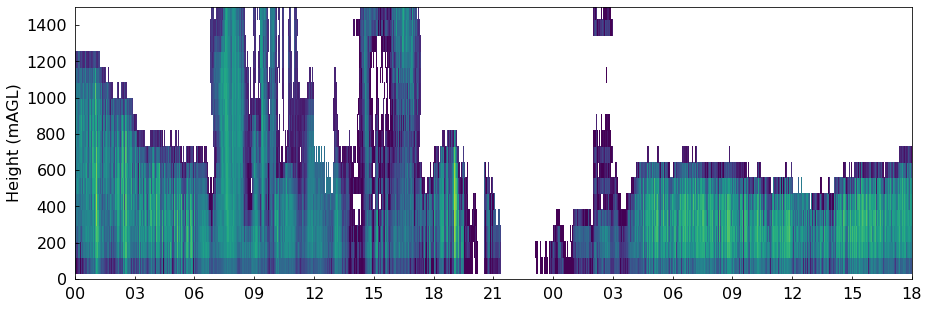

In [46]:

from matplotlib import rcParams
# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='8'
rcParams['ytick.major.pad']='8'

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(111)
rf = ax1.pcolormesh(all_times,Heights,np.transpose(Reflectivity),vmin=-50, vmax=20) 
ax1.set_ylabel('Height (mAGL)')
ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=1))

ax1.set_ylim(0,1500)
ax1.set_xlim(start,stop)

ax1.xaxis.set_major_formatter(md.DateFormatter('%H'))
#ax.xaxis.set_major_locator(md.DayLocator(bymonthday=1))
ax1.xaxis.set_major_locator(md.HourLocator(interval=3))
#ax1.grid('on')

#ax2 = fig.add_subplot(212)
##dp = ax2.pcolormesh(all_times,Heights,np.transpose(MeanDopplerVelocity),vmin=-2.7,vmax=2.7,cmap='Spectral') 
#ax2.set_ylabel('Height (mAGL)')
#ax2.xaxis.set_major_formatter(md.DateFormatter('%H'))
#ax2.xaxis.set_major_locator(md.HourLocator(interval=1))
#ax2.set_ylim(0,1500)
#ax2.set_xlim(start,stop)

#fig.tight_layout()    
#fig.subplots_adjust(right=0.9)
#cbar_ax1 = fig.add_axes([0.95, 0.55, 0.02, 0.4])
#cbar_ax2 = fig.add_axes([0.95, 0.05, 0.02, 0.4])
#fig.colorbar(rf,cax=cbar_ax1,label='Reflectivity, dbz')
#fig.colorbar(dp,cax=cbar_ax2,label='Mean Doppler Velocity, m/s')
